In [1]:
import matplotlib.pyplot as plt  
%matplotlib inline
from scipy.stats import norm

import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')
import random
import pandas as pd
import numpy as np  
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

In [2]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_parquet("bike_data_clean.parquet")


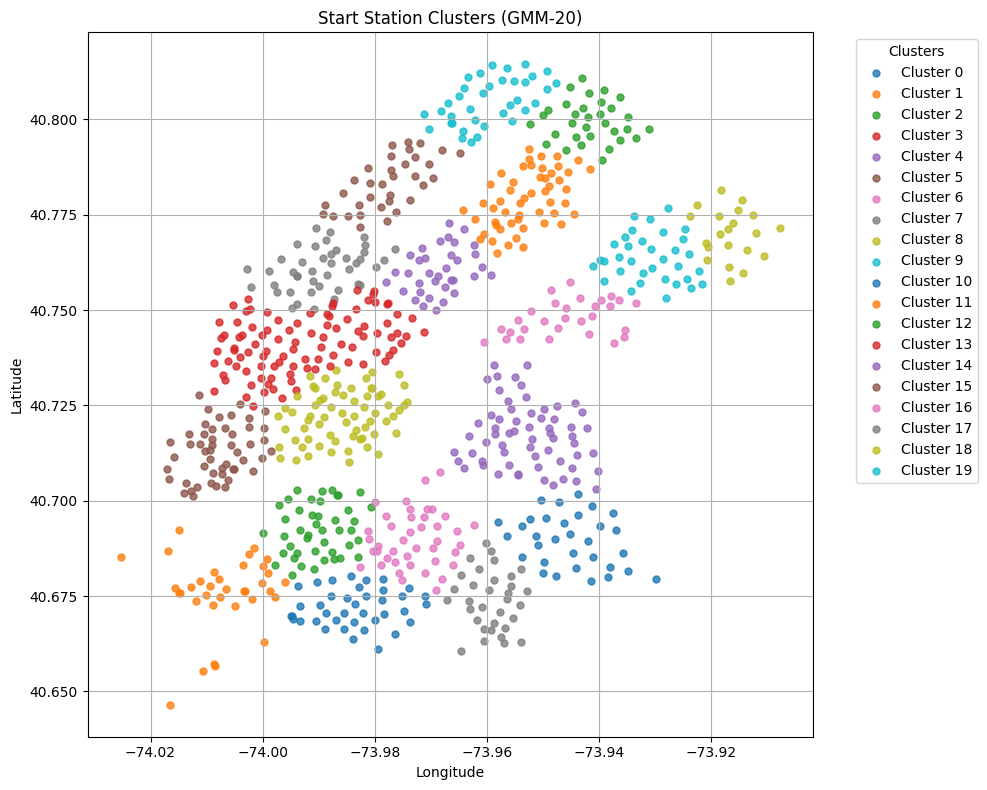

In [4]:
# Extract unique start stations with coordinates + cluster
stations = (
    df[['start_station_id', 'start_station_latitude', 
        'start_station_longitude', 'gmm20_cluster']]
    .drop_duplicates(subset='start_station_id')
)

# Create figure
plt.figure(figsize=(10, 8))

# Plot each cluster separately for legend clarity
clusters = sorted(stations['gmm20_cluster'].unique())

for c in clusters:
    cluster_points = stations[stations['gmm20_cluster'] == c]
    plt.scatter(
        cluster_points['start_station_longitude'],
        cluster_points['start_station_latitude'],
        s=25,
        label=f"Cluster {c}",
        alpha=0.8
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Start Station Clusters (GMM-20)")

plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Combine date + hour into real timestamps (minute ignored because aggregation is hourly)
df['start_datetime'] = df['start_date'] + pd.to_timedelta(df['start_hour'], unit='h')
df['stop_datetime']  = df['stop_date']  + pd.to_timedelta(df['stop_hour'],  unit='h')


In [6]:
departures = (
    df.groupby(['gmm20_cluster', 'start_datetime'])
      .size()
      .rename('departures')
)


In [7]:
arrivals = (
    df.groupby(['end_gmm20_cluster', 'stop_datetime'])
      .size()
      .rename('arrivals')
)


In [8]:
# Combine on multi-index (cluster, datetime)
cluster_hourly = pd.concat([departures, arrivals], axis=1).fillna(0)

# Reset index -> gives columns level_0, level_1
cluster_hourly = cluster_hourly.reset_index()

# FIX COLUMN NAMES
cluster_hourly = cluster_hourly.rename(columns={
    'level_0': 'cluster',
    'level_1': 'datetime_hour'
})

cluster_hourly.head()


,cluster,datetime_hour,departures,arrivals
0,0,2018-01-01 00:00:00,3.0,1.0
1,0,2018-01-01 01:00:00,2.0,4.0
2,0,2018-01-01 02:00:00,3.0,2.0
3,0,2018-01-01 03:00:00,4.0,7.0
4,0,2018-01-01 07:00:00,1.0,1.0


In [9]:
# 5) Add standard time-series features
cluster_hourly['weekday'] = cluster_hourly['datetime_hour'].dt.weekday.astype('int8')
cluster_hourly['hour']    = cluster_hourly['datetime_hour'].dt.hour.astype('int8')
cluster_hourly['month']   = cluster_hourly['datetime_hour'].dt.month.astype('int8')
cluster_hourly['year']    = cluster_hourly['datetime_hour'].dt.year.astype('int16')

In [10]:
cluster_hourly.head()

,cluster,datetime_hour,departures,arrivals,weekday,hour,month,year
0,0,2018-01-01 00:00:00,3.0,1.0,0,0,1,2018
1,0,2018-01-01 01:00:00,2.0,4.0,0,1,1,2018
2,0,2018-01-01 02:00:00,3.0,2.0,0,2,1,2018
3,0,2018-01-01 03:00:00,4.0,7.0,0,3,1,2018
4,0,2018-01-01 07:00:00,1.0,1.0,0,7,1,2018


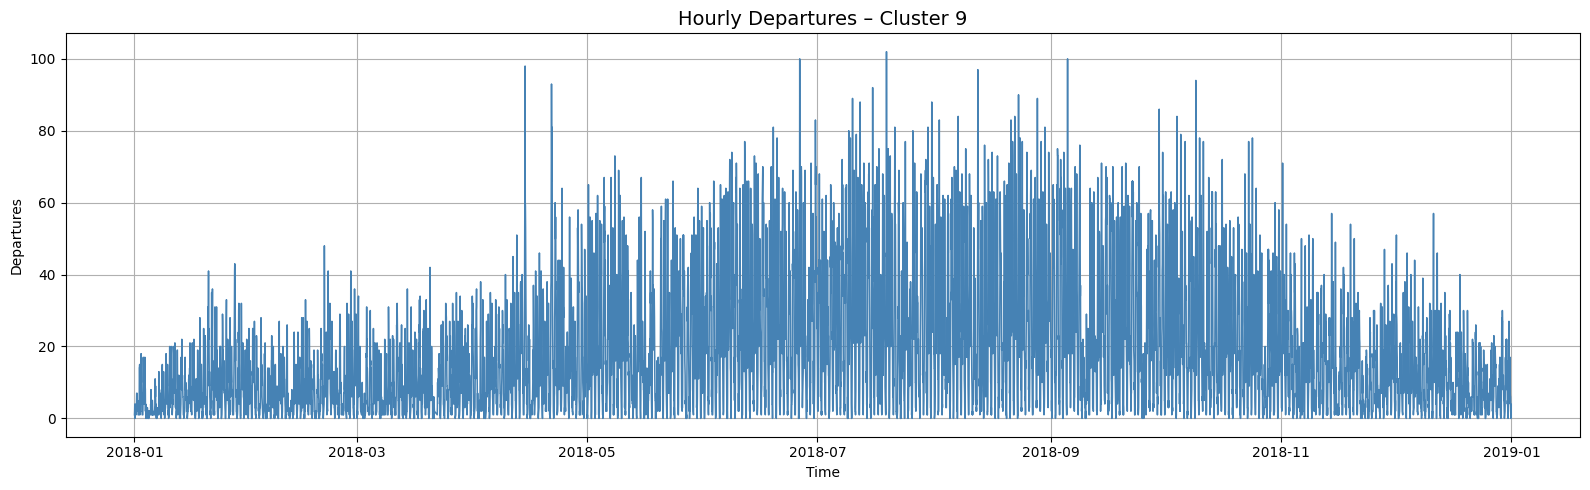

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cluster_id = 9

# Filter cluster 9
sub = cluster_hourly[cluster_hourly['cluster'] == cluster_id].copy()

# Ensure datetime is datetime64
sub['datetime_hour'] = pd.to_datetime(sub['datetime_hour'])

# Sort to ensure proper continuous time line
sub = sub.sort_values('datetime_hour')

# --- PLOT DEPARTURES ---
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=sub,
    x='datetime_hour',
    y='departures',
    linewidth=1.1,
    color='steelblue'
)
plt.title(f"Hourly Departures – Cluster {cluster_id}", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Departures")
plt.grid(True)
plt.tight_layout()
plt.show()


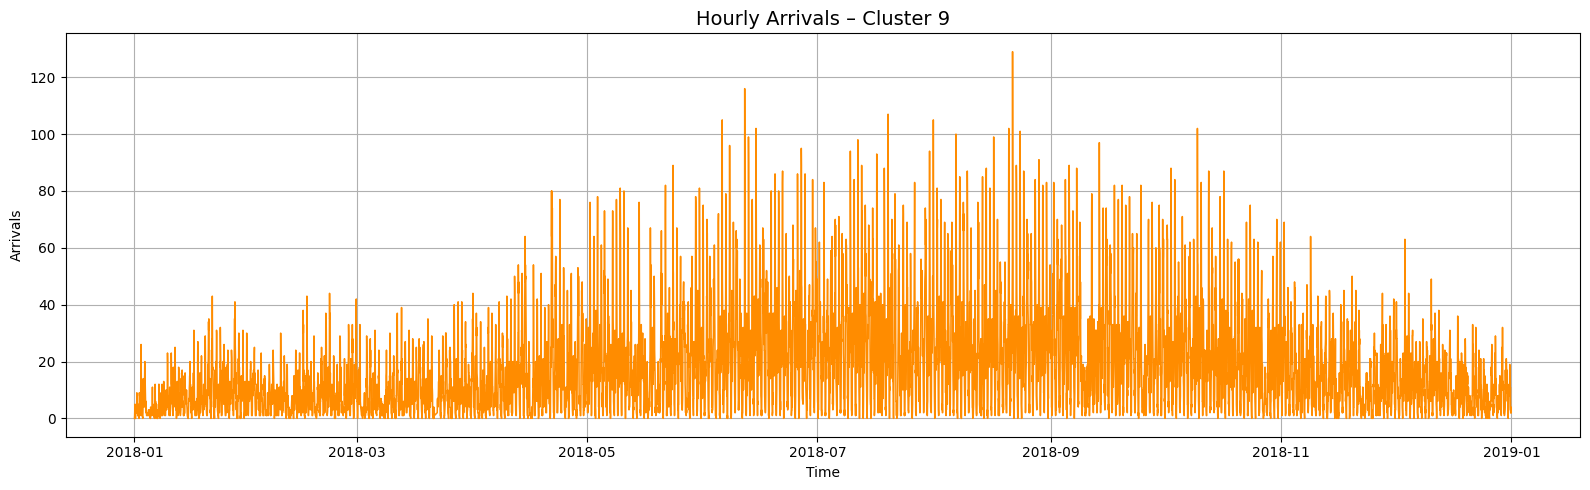

In [12]:
# --- PLOT ARRIVALS ---
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=sub,
    x='datetime_hour',
    y='arrivals',
    linewidth=1.1,
    color='darkorange'
)
plt.title(f"Hourly Arrivals – Cluster {cluster_id}", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Arrivals")
plt.grid(True)
plt.tight_layout()
plt.show()


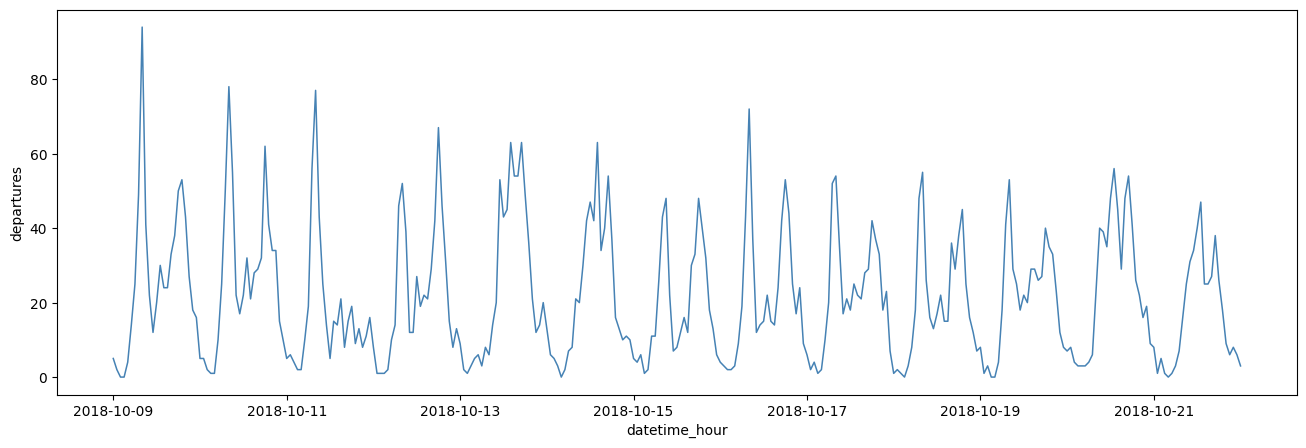

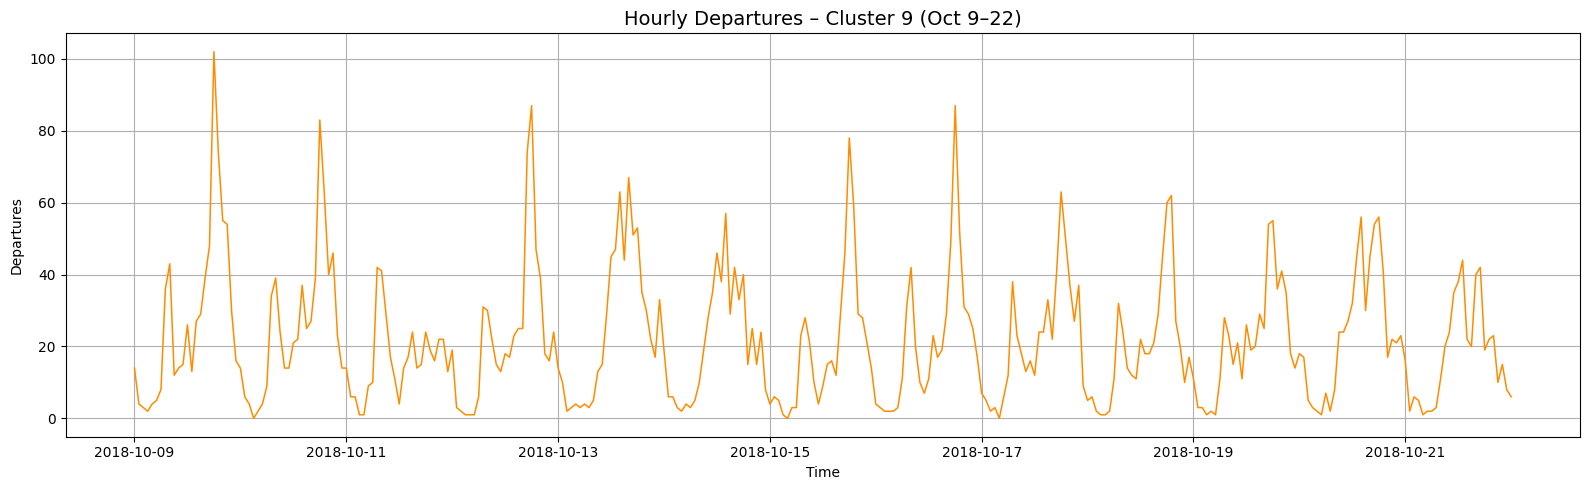

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cluster_id = 9

# Filter cluster 9
sub = cluster_hourly[cluster_hourly['cluster'] == cluster_id].copy()

# Ensure proper datetime type
sub['datetime_hour'] = pd.to_datetime(sub['datetime_hour'])

# Zoom window
start_zoom = "2018-10-09"
end_zoom   = "2018-10-22"

zoom = sub[(sub['datetime_hour'] >= start_zoom) & 
           (sub['datetime_hour'] <= end_zoom)]

# Plot departures
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=zoom,
    x='datetime_hour',
    y='departures',
    linewidth=1.1,
    color='steelblue'
)

plt.figure(figsize=(16, 5))
sns.lineplot(
    data=zoom,
    x='datetime_hour',
    y='arrivals',
    linewidth=1.1,
    color='darkorange'
)

plt.title(f"Hourly Departures – Cluster {cluster_id} (Oct 9–22)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Departures")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import r2_score, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
def plotprediction(series, pred_series, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    

    # Plot confidence intervals for smoothed values

    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [16]:
def print_stats(y_test, y_preds, title="You forgot the title!"):
    print(title+": ")
    print("\tr^2=%f"%r2_score(y_test,y_preds))
    print("\tMAE=%f"%mean_absolute_error(y_test,y_preds))
    print("\tMAPE=%f"%mean_absolute_percentage_error(y_test,y_preds))

In [17]:
cluster_hourly.head()

,cluster,datetime_hour,departures,arrivals,weekday,hour,month,year
0,0,2018-01-01 00:00:00,3.0,1.0,0,0,1,2018
1,0,2018-01-01 01:00:00,2.0,4.0,0,1,1,2018
2,0,2018-01-01 02:00:00,3.0,2.0,0,2,1,2018
3,0,2018-01-01 03:00:00,4.0,7.0,0,3,1,2018
4,0,2018-01-01 07:00:00,1.0,1.0,0,7,1,2018


In [18]:
cluster_hourly['datetime_hour'] = pd.to_datetime(cluster_hourly['datetime_hour'])
cluster_hourly = cluster_hourly.sort_values('datetime_hour').reset_index(drop=True)


In [19]:
train_df = cluster_hourly[cluster_hourly['month'] <= 10].copy()
test_df  = cluster_hourly[cluster_hourly['month'] >= 11].copy()

print(train_df.shape, test_df.shape)


(142723, 8) (28666, 8)


In [20]:
train_departures = train_df[['datetime_hour', 'departures']].copy()

# Ensure sorted (already done, but for safety)
train_departures = train_departures.sort_values('datetime_hour').reset_index(drop=True)

print(train_departures.head())


  datetime_hour  departures
0    2018-01-01         3.0
1    2018-01-01         7.0
2    2018-01-01         0.0
3    2018-01-01         3.0
4    2018-01-01         2.0


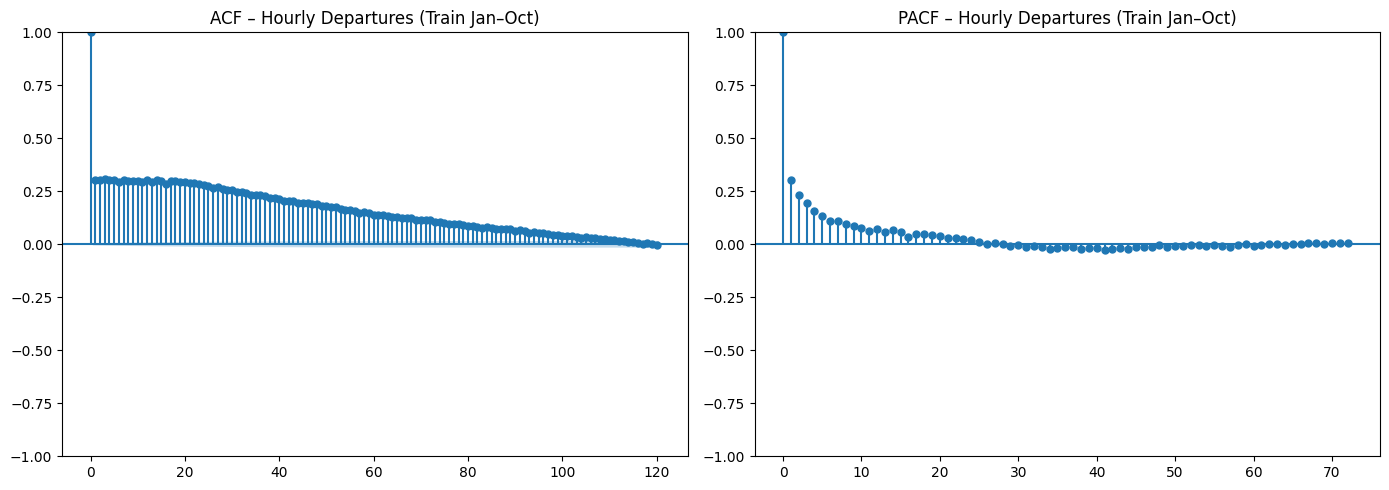

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(train_departures['departures'], lags=120, ax=plt.gca())
plt.title("ACF – Hourly Departures (Train Jan–Oct)")

plt.subplot(1, 2, 2)
plot_pacf(train_departures['departures'], lags=72, ax=plt.gca(), method='ywm')
plt.title("PACF – Hourly Departures (Train Jan–Oct)")

plt.tight_layout()
plt.show()


In [22]:
import pandas as pd

ts = train_departures.copy()
ts['datetime_hour'] = pd.to_datetime(ts['datetime_hour'])
ts = ts.set_index('datetime_hour')
ts = ts['departures']  # univariate series


In [36]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA parameters:
# ARIMA(p, d, q)
p = 20     # from PACF
d = 1      # slow decay → non-stationary
q = 0      # PACF decays, ACF no strong spikes → q small

# Seasonal SARIMA(P, D, Q, s)
P = 1
D = 1
Q = 1
s = 24     # 24-hour daily seasonality

model = SARIMAX(
    ts,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())


: 